## Prevendo o Preço de Ações do Banco do Brasil com Algoritmo Prophet

In [2]:
import plotly.express as px
import yfinance as yf
from datetime import date
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
# Download dos dados históricos
ticker = 'BBAS3.SA'
start_date = '2020-01-01'
end_date = date.today()

stock_data = yf.Ticker(ticker)

stock_data = stock_data.history(period='1d', start=start_date, end=end_date)

stock_data = stock_data.reset_index('Date')

stock_data['Date'] = stock_data['Date'].apply(lambda x: x.replace(tzinfo=None))

In [4]:
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-01-02,19.731195,19.960499,19.664623,19.897625,26319800,0.0,0.0
1,2020-01-03,19.638735,19.938309,19.546273,19.864340,18930800,0.0,0.0
2,2020-01-06,19.749692,19.749692,19.398339,19.601753,19999800,0.0,0.0
3,2020-01-07,19.601752,19.612847,19.339163,19.453814,21277000,0.0,0.0
4,2020-01-08,19.512985,19.598051,19.246698,19.276285,42937200,0.0,0.0


In [5]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331 entries, 0 to 1330
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1331 non-null   datetime64[ns]
 1   Open          1331 non-null   float64       
 2   High          1331 non-null   float64       
 3   Low           1331 non-null   float64       
 4   Close         1331 non-null   float64       
 5   Volume        1331 non-null   int64         
 6   Dividends     1331 non-null   float64       
 7   Stock Splits  1331 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 83.3 KB


In [6]:
stock_data.describe()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1331,1331.000000,1331.000000,1331.000000,1331.000000,1.331000e+03,1331.000000,1331.000000
mean,2022-09-05 04:57:31.239669504,18.331864,18.544369,18.106921,18.319554,2.798135e+07,0.004534,0.001503
min,2020-01-02 00:00:00,9.076256,9.376297,8.217387,8.299898,0.000000e+00,0.000000,0.000000
25%,2021-05-08 12:00:00,12.904627,13.087643,12.716253,12.902761,1.672810e+07,0.000000,0.000000
50%,2022-09-05 00:00:00,16.959736,17.256417,16.741180,16.968475,2.353380e+07,0.000000,0.000000
75%,2024-01-08 12:00:00,24.682721,24.983259,24.374712,24.635057,3.467580e+07,0.000000,0.000000
max,2025-05-09 00:00:00,29.500000,30.040001,29.459999,29.530001,2.040722e+08,0.483304,2.000000
std,NaN,5.878164,5.884547,5.870820,5.887379,1.694024e+07,0.032912,0.054820


In [7]:
# Visualizar valores de fechamento ao longo do tempo
px.line(stock_data, x='Date', y='Close')

In [8]:
# Manter apenas colunas de data e valor de fechamento
stock_data = stock_data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [9]:
# Treinar e testar modelo
train_data = stock_data.sample(frac=0.8, random_state=0)
test_data = stock_data.drop(train_data.index)

model = Prophet(daily_seasonality=True)

model.fit(train_data)

future_dates = model.make_future_dataframe(periods=len(test_data), freq='D')

forecast = model.predict(future_dates)

forecast.tail(len(test_data))


13:55:27 - cmdstanpy - INFO - Chain [1] start processing


13:55:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1065,2025-05-10,28.171666,25.855261,28.643527,28.171666,28.171666,-0.930085,-0.930085,-0.930085,-0.922279,...,0.115285,0.115285,0.115285,-0.123091,-0.123091,-0.123091,0.0,0.0,0.0,27.241581
1066,2025-05-11,28.174451,25.887730,28.642743,28.174451,28.174451,-0.924793,-0.924793,-0.924793,-0.922279,...,0.115285,0.115285,0.115285,-0.117799,-0.117799,-0.117799,0.0,0.0,0.0,27.249659
1067,2025-05-12,28.177236,25.778091,28.429821,28.177236,28.177236,-1.099290,-1.099290,-1.099290,-0.922279,...,-0.065382,-0.065382,-0.065382,-0.111630,-0.111630,-0.111630,0.0,0.0,0.0,27.077946
1068,2025-05-13,28.180021,25.757183,28.513109,28.180021,28.180021,-1.031757,-1.031757,-1.031757,-0.922279,...,-0.005124,-0.005124,-0.005124,-0.104354,-0.104354,-0.104354,0.0,0.0,0.0,27.148265
1069,2025-05-14,28.182806,25.756729,28.663907,28.182806,28.182806,-1.017352,-1.017352,-1.017352,-0.922279,...,0.000640,0.000640,0.000640,-0.095713,-0.095713,-0.095713,0.0,0.0,0.0,27.165454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,2026-01-26,28.898529,25.323858,30.480976,26.489361,31.012612,-0.578707,-0.578707,-0.578707,-0.922279,...,-0.065382,-0.065382,-0.065382,0.408954,0.408954,0.408954,0.0,0.0,0.0,28.319822
1327,2026-01-27,28.901314,25.471201,30.975067,26.483692,31.029673,-0.487757,-0.487757,-0.487757,-0.922279,...,-0.005124,-0.005124,-0.005124,0.439646,0.439646,0.439646,0.0,0.0,0.0,28.413557
1328,2026-01-28,28.904099,25.677483,30.832791,26.478023,31.045826,-0.452023,-0.452023,-0.452023,-0.922279,...,0.000640,0.000640,0.000640,0.469616,0.469616,0.469616,0.0,0.0,0.0,28.452076
1329,2026-01-29,28.906884,25.642971,30.904626,26.471254,31.058591,-0.534200,-0.534200,-0.534200,-0.922279,...,-0.111099,-0.111099,-0.111099,0.499178,0.499178,0.499178,0.0,0.0,0.0,28.372684


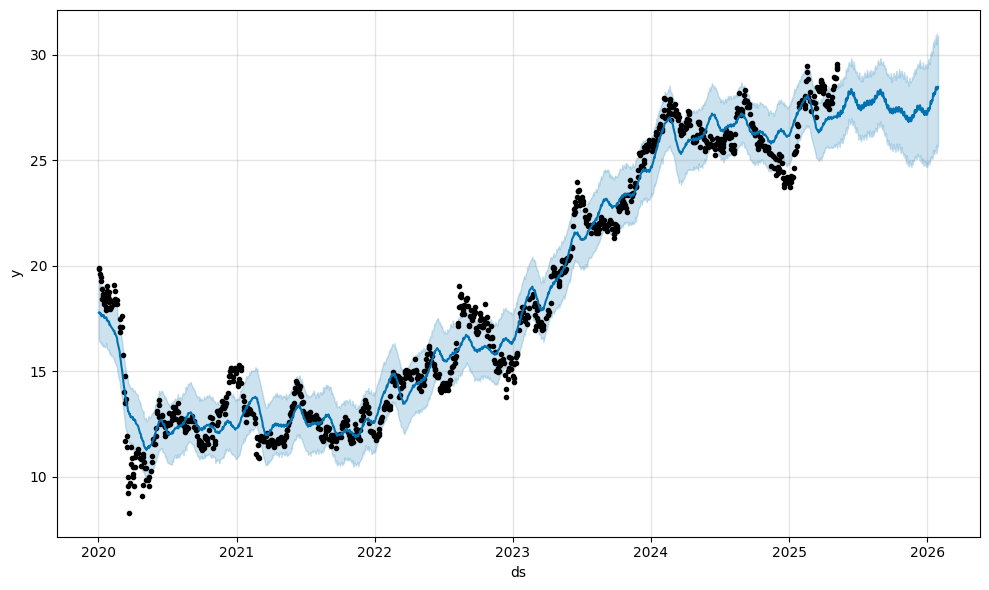

In [10]:
# Visualizar resultados do modelo
model.plot(forecast);

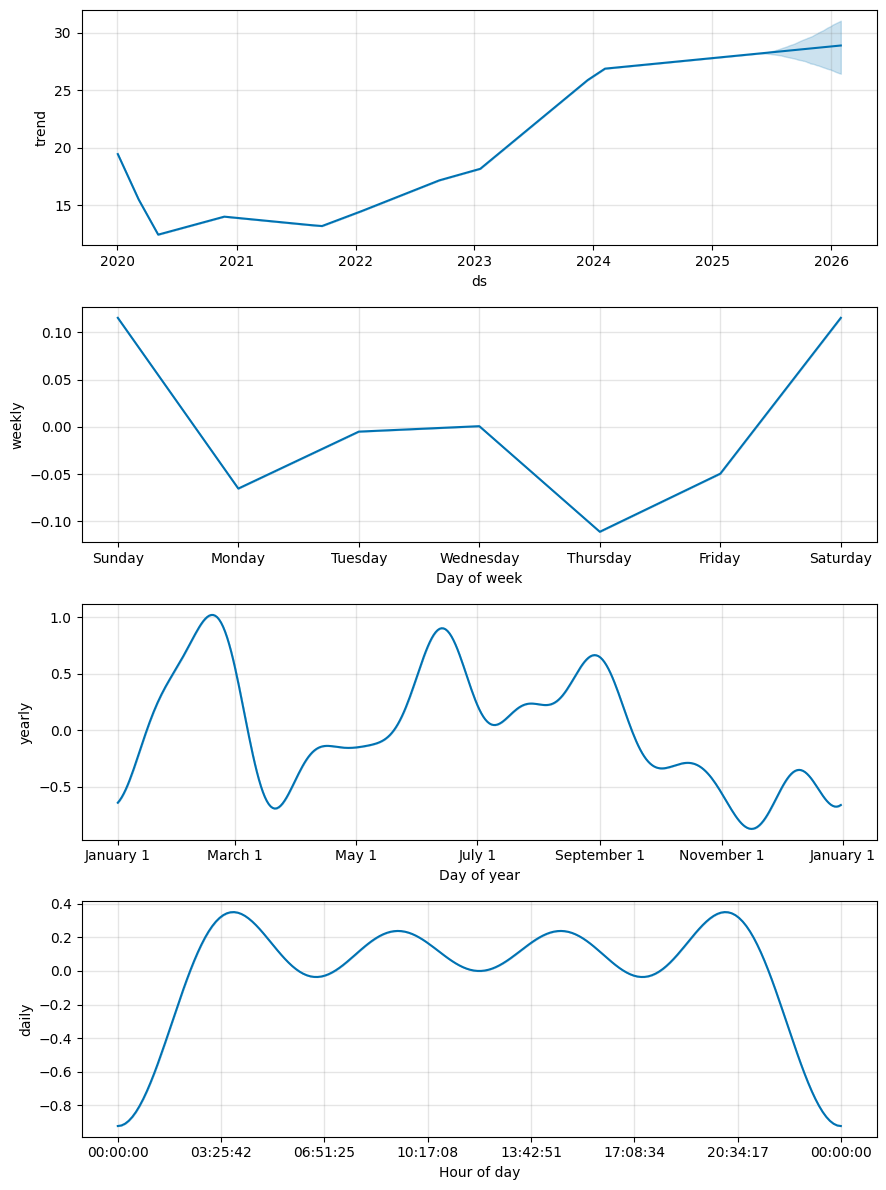

In [11]:
# Visualizar componentes do modelo
model.plot_components(forecast);

In [12]:
# Métricas de avaliação do modelo
metrics = forecast.set_index('ds')[['yhat']].join(stock_data.set_index('ds').y).reset_index()

metrics.tail()

,ds,yhat,y
1326,2026-01-26,28.319822,NaN
1327,2026-01-27,28.413557,NaN
1328,2026-01-28,28.452076,NaN
1329,2026-01-29,28.372684,NaN
1330,2026-01-30,28.466416,NaN


In [13]:
metrics.dropna(inplace=True)

metrics.tail()

,ds,yhat,y
1060,2025-05-02,27.027214,28.900000
1061,2025-05-06,27.094163,28.900000
1062,2025-05-07,27.106139,29.309999
1063,2025-05-08,27.000906,29.410000
1064,2025-05-09,27.069290,29.530001


In [14]:
# Mean Squared Error
mse = mean_squared_error(metrics.y, metrics.yhat)

print(f"MSE: {mse:.2f}")

# Root Mean Squared Error
rmse = root_mean_squared_error(metrics.y, metrics.yhat)

print(f"RMSE: {rmse:.2f}")

# Mean Absolute Error
mae = mean_absolute_error(metrics.y, metrics.yhat)

print(f"MAE: {mae:.2f}")

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(metrics.y, metrics.yhat)

print(f"MAPE: {round(mape * 100, 2)}%")

MSE: 1.15
RMSE: 1.07
MAE: 0.86
MAPE: 5.17%


In [15]:
# Visualizar diferença entre os valores previstos em comparação com os valores de fechamento reais
px.line(metrics, x='ds', y=['y', 'yhat'])

In [16]:
# Cross-validation
df_cv = cross_validation(model, initial='730 days', period='60 days', horizon='365 days')

  0%|          | 0/15 [00:00<?, ?it/s]13:55:29 - cmdstanpy - INFO - Chain [1] start processing
13:55:29 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/15 [00:00<00:02,  6.47it/s]13:55:29 - cmdstanpy - INFO - Chain [1] start processing
13:55:29 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 2/15 [00:00<00:02,  5.84it/s]13:55:29 - cmdstanpy - INFO - Chain [1] start processing
13:55:29 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 3/15 [00:00<00:02,  5.52it/s]13:55:29 - cmdstanpy - INFO - Chain [1] start processing
13:55:29 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 4/15 [00:00<00:01,  5.82it/s]13:55:30 - cmdstanpy - INFO - Chain [1] start processing
13:55:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 5/15 [00:00<00:01,  5.94it/s]13:55:30 - cmdstanpy - INFO - Chain [1] start processing
13:55:30 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 6/15 [00:01<00:01,  5.75it/s]13:55:30

In [17]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-25,11.855519,10.954560,12.681323,13.330659,2022-01-20
1,2022-01-26,11.827177,10.997817,12.759351,13.202165,2022-01-20
2,2022-01-27,11.722581,10.841617,12.670979,13.384548,2022-01-20
3,2022-01-31,11.669342,10.789843,12.522407,13.537914,2022-01-20
4,2022-02-01,11.740538,10.902786,12.632992,13.517189,2022-01-20
...,...,...,...,...,...,...
2954,2025-05-02,36.059567,31.226693,40.741012,28.900000,2024-05-09
2955,2025-05-06,36.192964,31.167976,41.124143,28.900000,2024-05-09
2956,2025-05-07,36.255747,31.505630,41.132544,29.309999,2024-05-09
2957,2025-05-08,36.247497,31.217022,41.405759,29.410000,2024-05-09


In [18]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,4.620238,2.149474,1.649244,0.093393,0.059170,0.092672,0.508475
1,38 days,4.684473,2.164364,1.664794,0.094086,0.061673,0.093224,0.497458
2,39 days,4.852005,2.202727,1.702370,0.095865,0.064602,0.094871,0.481356
3,40 days,5.016956,2.239856,1.735176,0.097357,0.065291,0.096213,0.469492
4,41 days,5.187442,2.277596,1.768369,0.099489,0.067112,0.098239,0.461633
...,...,...,...,...,...,...,...,...
324,361 days,30.445020,5.517701,4.746242,0.199554,0.187274,0.200790,0.474576
325,362 days,31.226808,5.588095,4.815967,0.202130,0.189546,0.202898,0.464407
326,363 days,31.309679,5.595505,4.807470,0.201969,0.189546,0.202937,0.466256
327,364 days,31.291463,5.593877,4.796821,0.201917,0.189546,0.203104,0.470878


In [19]:
print(f"Média MSE: {round(performance_metrics(df_cv)['mse'].mean(), 2)}")

print(f"Média RMSE: {round(performance_metrics(df_cv)['rmse'].mean(), 2)}")

print(f"Média MAE: {round(performance_metrics(df_cv)['mae'].mean(), 2)}")

print(f"Média MAPE: {round(performance_metrics(df_cv)['mape'].mean() * 100, 2)}%")

Média MSE: 18.55
Média RMSE: 4.18
Média MAE: 3.51
Média MAPE: 16.62%
